## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !unzip /content/drive/MyDrive/Python_pet_project/DATA.zip

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import random
import tqdm
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.applications import densenet

In [19]:
path = '/content/DATA'
img_path = '/content/DATA/1812.png'

## Preprocessors

### Degrade image

In [6]:
def degrade_image(img: np.ndarray) -> np.ndarray:
    """
    Safe degradation: JPEG + Gaussian Blur + Noise + Brightness/Contrast + Motion Blur
    """
    img = img.copy()

    # JPEG compression
    if random.random() < 0.8:
        quality = random.randint(50, 90)
        img_uint8 = img.astype(np.uint8)
        success, enc = cv2.imencode('.jpg', img_uint8, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
        if success and enc is not None and enc.size > 0:
            img = cv2.imdecode(enc, cv2.IMREAD_COLOR)
        # else: оставляем img без изменений

    # Gaussian Blur
    if random.random() < 0.5:
        k = random.choice([3, 5])
        sigma = random.uniform(0.3, 1.2)
        img = cv2.GaussianBlur(img, (k, k), sigma)

    # Gaussian Noise
    if random.random() < 0.4:
        std = random.uniform(3, 10)
        noise = np.random.normal(0, std, img.shape).astype(np.float32)
        img = img.astype(np.float32) + noise
        img = np.clip(img, 0, 255).astype(np.uint8)

    # Brightness / Contrast
    if random.random() < 0.3:
        alpha = random.uniform(0.9, 1.1)
        beta = random.randint(-10, 10)
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # Motion Blur
    if random.random() < 0.1:
        k = random.randint(5, 10)
        kernel = np.zeros((k, k))
        kernel[k // 2, :] = 1.0
        kernel /= kernel.sum()
        img = cv2.filter2D(img, -1, kernel)

    return img

### Make patches

In [43]:
def extract_patches(img, patch_size=224, step=224):
    H, W, C = img.shape

    patches = []
    positions = []

    y_poss = list(range(0, H - patch_size + 1, step))
    if y_poss[-1] + patch_size < H:
        y_poss.append(H - patch_size)

    x_poss = list(range(0, W - patch_size + 1, step))
    if x_poss[-1] + patch_size < W:
        x_poss.append(W - patch_size)

    for y in y_poss:
        for x in x_poss:
            patches.append(img[y:y+patch_size, x:x+patch_size])
            positions.append((y, x))

    return np.array(patches), positions, H, W

In [36]:
def merge_patches(patches, positions, H, W, patch_size):
    C = patches[0].shape[2]
    output = np.zeros((H, W, C), dtype=np.float32)
    weight = np.zeros((H, W, C), dtype=np.float32)

    for patch, (y, x) in zip(patches, positions):
        output[y:y+patch_size, x:x+patch_size] += patch
        weight[y:y+patch_size, x:x+patch_size] += 1

    output /= np.maximum(weight, 1e-8)
    return output.astype(np.uint8)

### Padding

In [9]:
def pad_to_square(img: np.ndarray, patch_size: int, pad_mode: str = "reflect"):
    """
    Делает изображение:
    - квадратным
    - размер кратен patch_size
    Возвращает padded_img и pad_info (для обратного удаления)
    """

    if img.ndim != 3:
        raise ValueError(f"Expected (H, W, C), got {img.shape}")

    h, w, c = img.shape

    # 1. Делаем квадрат
    side = max(h, w)

    # 2. Делаем кратным patch_size
    target = ((side + patch_size - 1) // patch_size) * patch_size

    pad_h = target - h
    pad_w = target - w

    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    padded = np.pad(
        img,
        ((top, bottom), (left, right), (0, 0)),
        mode=pad_mode
    )

    pad_info = {
        "top": top,
        "bottom": bottom,
        "left": left,
        "right": right,
        "orig_shape": (h, w)
    }

    return padded, pad_info

In [10]:
def unpad_image(img: np.ndarray, pad_info: dict):
    """
    Убирает padding и возвращает изображение
    к исходному размеру
    """

    top = pad_info["top"]
    bottom = pad_info["bottom"]
    left = pad_info["left"]
    right = pad_info["right"]

    h, w = pad_info["orig_shape"]

    return img[
        top : top + h,
        left : left + w
    ]


### Batch generator

In [13]:
IMG_SIZE = 224
STEP = IMG_SIZE
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

all_paths = [os.path.join(path, f)
             for f in os.listdir(path)
             if f.lower().endswith(('.jpg', '.png'))]

random.shuffle(all_paths)
split = int(0.8 * len(all_paths))
train_paths = all_paths[:split]
val_paths = all_paths[split:]

paths = [os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png'))]

def patch_generator(paths, patch_size=IMG_SIZE, step=STEP):
    """
    Generator that yields degraded input patches and corresponding target patches
    for image-to-image network training using TensorFlow.

    Pipeline:
    1. Reads an image from disk using OpenCV.
    2. Converts the image from BGR to RGB.
    3. Pads the image to a square with size multiple of `patch_size` using `pad_to_square`.
    4. Extracts non-overlapping or overlapping patches from the padded image using `extract_patches`.
    5. For each patch:
       a. Normalizes the target patch to [-1, 1].
       b. Applies degradation multiple times to create the input patch and normalizes to [-1, 1].
    6. Yields a tuple (input_patch, target_patch) for each patch.

    Args:
        paths (list of str): List of file paths to the images.
        patch_size (int, optional): Size of each square patch. Default is IMG_SIZE.
        step (int, optional): Step size between patches. Default is STEP.

    Yields:
        tuple:
            x (np.ndarray): Degraded and normalized input patch, shape (patch_size, patch_size, 3), dtype float32.
            y (np.ndarray): Normalized target patch, shape (patch_size, patch_size, 3), dtype float32.

    Notes:
        - Multiple calls to `degrade_image` can be used to simulate stronger degradation.
        - This generator is compatible with `tf.data.Dataset.from_generator` for memory-efficient training.
        - Batch size and prefetching should be handled outside the generator using Dataset API.
    """

# -------------------------
# Generator
# -------------------------
    for path in paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img, _ = pad_to_square(img, patch_size=patch_size)
        patches, _, _ = extract_patches(img, patch_size=patch_size, step=step)

        for patch in patches:
            y = patch.astype(np.float32) / 127.5 - 1.0  # target [-1,1]

            x = degrade_image(patch)
            x = degrade_image(x)
            x = degrade_image(x)
            x = x.astype(np.float32) / 127.5 - 1.0  # input [-1,1]

            yield x, y

# -------------------------
# create tf.data.Dataset
# -------------------------
train_dataset = tf.data.Dataset.from_generator(
    lambda: patch_generator(train_paths),
    output_signature=(
        tf.TensorSpec((IMG_SIZE, IMG_SIZE, 3), tf.float32),
        tf.TensorSpec((IMG_SIZE, IMG_SIZE, 3), tf.float32)
    )
).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: patch_generator(val_paths),
    output_signature=(
        tf.TensorSpec((IMG_SIZE, IMG_SIZE, 3), tf.float32),
        tf.TensorSpec((IMG_SIZE, IMG_SIZE, 3), tf.float32)
    )
).batch(BATCH_SIZE).prefetch(AUTOTUNE)

print(f"Train patches: {len(train_paths)}, Validation patches: {len(val_paths)}")

Train patches: 5519, Validation patches: 1380


## Predict

In [45]:
def predict_img(model, img_src):
  img = cv2.imread(img_src)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img, pad_info = pad_to_square(img, patch_size=IMG_SIZE)
  patches, pos, H, W = extract_patches(img, patch_size=IMG_SIZE, step=STEP)

  X = []
  for patch in patches:
    x = patch.astype(np.float32) / 127.5 - 1.0
    X.append(x)

  X = np.array(X)

  preds = model.predict(X)

  preds = (preds + 1.0) * 127.5
  preds = preds.astype(np.uint8)

  img = merge_patches(patches, pos, H, W, patch_size=224)
  img = unpad_image(img, pad_info)

  return img

In [39]:
def show_before_after(model, img_path):
    # original
    orig = cv2.imread(img_path)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    # predicted
    pred = predict_img(model, img_path)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(orig)
    plt.title("Original image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred)
    plt.title("Enhanced image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

## Model Building

In [14]:
# -------------------------
# INPUT
# -------------------------
inp = Input(shape=(224, 224, 3), name='input_image')

# -------------------------
# ENCODER
# -------------------------
# skip 1
x = Conv2D(16, 3, activation='relu', padding='same', name='enc1-conv1')(inp)
x = Conv2D(16, 3, activation='relu', padding='same', name='enc1-conv2')(x)
skip1 = x
x = MaxPool2D(2, name='enc1-pool')(x)

# skip 2
x = Conv2D(32, 3, activation='relu', padding='same', name='enc2-conv1')(x)
x = Conv2D(32, 3, activation='relu', padding='same', name='enc2-conv2')(x)
skip2 = x
x = MaxPool2D(2, name='enc2-pool')(x)

# skip 3
x = Conv2D(64, 3, activation='relu', padding='same', name='enc3-conv1')(x)
x = Conv2D(64, 3, activation='relu', padding='same', name='enc3-conv2')(x)
skip3 = x
x = MaxPool2D(2, name='enc3-pool')(x)

# skip 4
x = Conv2D(128, 3, activation='relu', padding='same', name='enc4-conv1')(x)
x = Conv2D(128, 3, activation='relu', padding='same', name='enc4-conv2')(x)
skip4 = x
x = MaxPool2D(2, name='enc4-pool')(x)

# skip 5
x = Conv2D(256, 3, activation='relu', padding='same', name='enc5-conv1')(x)
x = Conv2D(256, 3, activation='relu', padding='same', name='enc5-conv2')(x)
skip5 = x
x = MaxPool2D(2, name='enc5-pool')(x)

# -------------------------
# BOTTLENECK
# -------------------------
x = Conv2D(512, 3, activation='relu', padding='same', name='botn-conv1')(x)
x = Conv2D(512, 3, activation='relu', padding='same', name='botn-conv2')(x)
botn = x

# -------------------------
# DECODER
# -------------------------
# up 1
x = UpSampling2D(2, name='dec1-up')(botn)
x = Concatenate(name='concat1')([x, skip5])
x = Conv2D(256, 3, activation='relu', padding='same', name='dec1-conv1')(x)
x = Conv2D(256, 3, activation='relu', padding='same', name='dec1-conv2')(x)

# up 2
x = UpSampling2D(2, name='dec2-up')(x)
x = Concatenate(name='concat2')([x, skip4])
x = Conv2D(128, 3, activation='relu', padding='same', name='dec2-conv1')(x)
x = Conv2D(128, 3, activation='relu', padding='same', name='dec2-conv2')(x)

# up 3
x = UpSampling2D(2, name='dec3-up')(x)
x = Concatenate(name='concat3')([x, skip3])
x = Conv2D(64, 3, activation='relu', padding='same', name='dec3-conv1')(x)
x = Conv2D(64, 3, activation='relu', padding='same', name='dec3-conv2')(x)

# up 4
x = UpSampling2D(2, name='dec4-up')(x)
x = Concatenate(name='concat4')([x, skip2])
x = Conv2D(32, 3, activation='relu', padding='same', name='dec4-conv1')(x)
x = Conv2D(32, 3, activation='relu', padding='same', name='dec4-conv2')(x)

# up 5
x = UpSampling2D(2, name='dec5-up')(x)
x = Concatenate(name='concat5')([x, skip1])
x = Conv2D(16, 3, activation='relu', padding='same', name='dec5-conv1')(x)
x = Conv2D(16, 3, activation='relu', padding='same', name='dec5-conv2')(x)

# -------------------------
# OUTPUT
# -------------------------
outputs = Conv2D(3, 1, activation='tanh', padding='same', name='output')(x)

# -------------------------
# MODEL
# -------------------------
model = tf.keras.Model(inputs=inp, outputs=outputs, name='UNet_5level_16start')
# model.summary()


In [15]:
model.compile(optimizer='adam', loss='mse')

In [17]:
steps_per_epoch = len(train_paths)

model.fit(train_dataset,
          epochs=20,
          validation_data=val_dataset)

Epoch 1/20
    565/Unknown 231s 390ms/step - loss: 0.0173

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


565/565 ━━━━━━━━━━━━━━━━━━━━ 286s 489ms/step - loss: 0.0173 - val_loss: 0.0131
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 302s 518ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 291s 494ms/step - loss: 0.0119 - val_loss: 0.0121
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 267s 446ms/step - loss: 0.0117 - val_loss: 0.0120
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 264s 450ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 6/20
201/565 ━━━━━━━━━━━━━━━━━━━━ 2:18 381ms/step - loss: 0.0110

KeyboardInterrupt: 

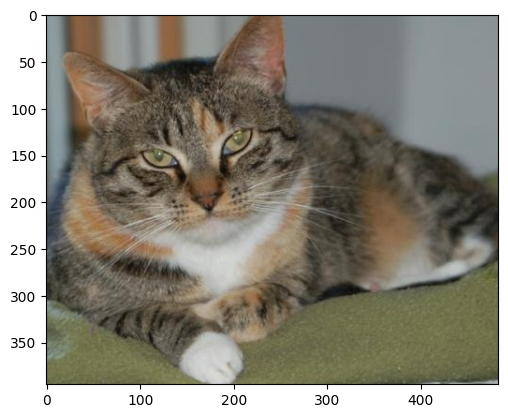

In [40]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

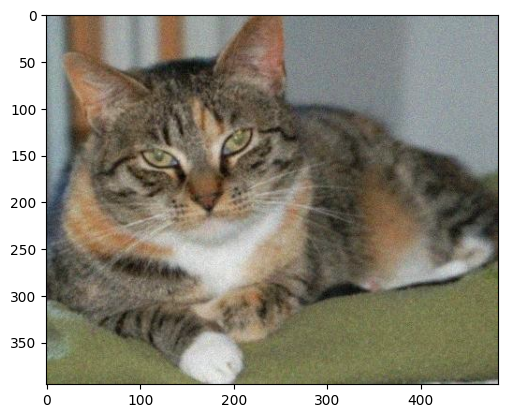

In [51]:
img = degrade_image(img)
img = degrade_image(img)
img = degrade_image(img)
plt.imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


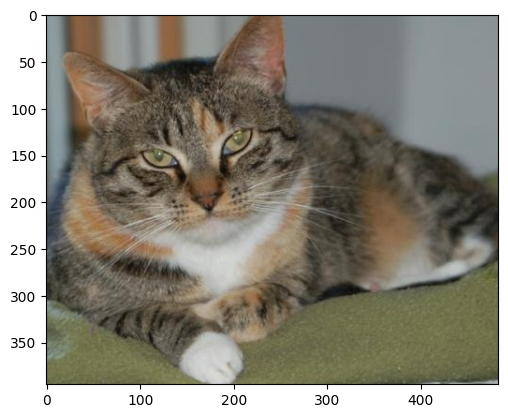

In [52]:
img = predict_img(model, img_path)
plt.imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


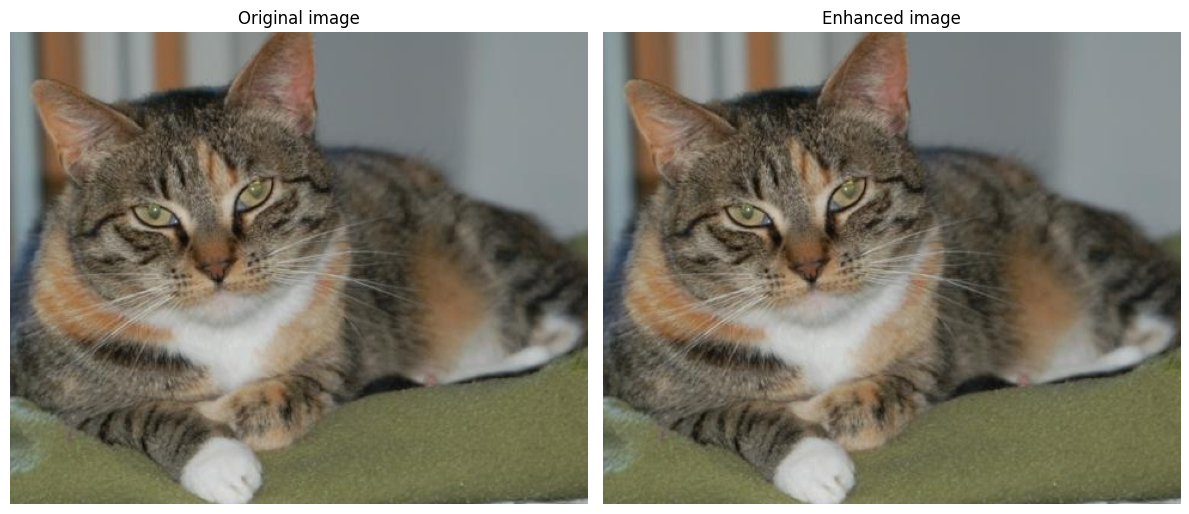

In [49]:
show_before_after(model, img_path)

In [56]:
model.save('model.h5')

In [57]:
p = '/content/model.h5'

In [59]:
from google.colab import files
files.download(p)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>